# Processamento de Streams 2022
## TP1 - Air Quality Monitoring (airborne particulate matter)





Authors: Diogo Silva nº53058 and Eugen Ursu nº52533

The goal of this project is to analyze data provided by a set of air quality sensors [sds011](https://aqicn.org/sensor/sds011/pt/). The sensors present in the dataset are located in Portugal, namely in the Lisbon metro area. Each sensor provides two values: measuring particles less than 10 µm (P1) and less than 2.5 µm (P2) in μg/m³.

The sensor data, spans the first half of 2020, and is streamed of Kafka.

Each data sample has the following schema:

sensor_id | sensor_type | location | latitude | longitude | timestamp | P1 | P2
----------|-------------|----------|----------|-----------|-----------|----|---
string  | string | string | float | float| timestamp | float | float



## Questions


1. Find the time of day with the poorest air quality, for each location. Updated daily;
2. Find the average air quality, for each location. Updated hourly;
3. Can you show any daily and/or weekly patterns to air quality?;
4. The data covers a period of extensive population confinement due to Covid 19. Can you find a signal in the data showing air quality improvement coinciding with the confinement period?

---
### Colab Setup


In [ ]:
#@title Mount Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Install PySpark
!pip install pyspark findspark --quiet
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.7/dist-packages/pyspark'

In [ ]:
#@title Install & Launch Kafka
%%bash
KAFKA_VERSION=3.1.0
KAFKA=kafka_2.13-$KAFKA_VERSION
wget -q -O /tmp/$KAFKA.tgz https://dlcdn.apache.org/kafka/$KAFKA_VERSION/$KAFKA.tgz
tar xfz /tmp/$KAFKA.tgz
wget -q -O $KAFKA/config/server1.properties - https://github.com/smduarte/ps2022/raw/main/colab/server1.properties

UUID=`$KAFKA/bin/kafka-storage.sh random-uuid`
$KAFKA/bin/kafka-storage.sh format -t $UUID -c $KAFKA/config/server1.properties
$KAFKA/bin/kafka-server-start.sh -daemon $KAFKA/config/server1.properties


Log directory /tmp/kraft-combined-logs is already formatted. Use --ignore-formatted to ignore this directory and format the others.


### Air quality sensor data publisher
This a small python Kafka client that publishes a continous stream of text lines, obtained from the periodic output of the sensors.

* The Kafka server is accessible @localhost:9092
* The events are published to the `air_quality` topic
* Events are published 3600x faster than realtime relative to the timestamp


In [ ]:
#@title Start Kafka Publisher
%%bash
pip install kafka-python dataclasses --quiet
wget -q -O - https://github.com/smduarte/ps2022/raw/main/colab/kafka-tp1-logsender.tgz | tar xfz - 2> /dev/null

cd kafka-tp1-logsender
nohup python publisher.py --filename 2020-01-06_sds011-pt.csv --topic air_quality  --speedup 3600 2> publisher-error.log > publisher-out.log &

In [ ]:
#@title Start Socket-based Publisher
%%bash

git clone https://github.com/smduarte/ps2022.git 2> /dev/null > /dev/null || git -C ps2022 pull
cd ps2022/colab/socket-tp1-logsender/

nohup python publisher.py --filename 2020-01-06_sds011-pt.csv --port 7777  --speedup 3600 2> /tmp/publisher-error.log > /tmp/publisher-out.log &

Already up to date.


Each line sample has the following parts separated by blanks:

sensor_id | sensor_type | location | latitude | longitude | P1 | P2 | timestamp
----------|-------------|----------|----------|-----------|-----------|----|---
string  | string | string | float | float| float | float | timestamp



###Answers

Seeing as the events are published 3600x faster than realtime, a window with 24 seconds corresponds to 24 hours (1 day).
Seeing as p2 is always lower than p1, we decided that for questions 1 and 2, p2 is not necessary to use and p1 is enough. We defined air quality in function of p1.

1. Find the time of day with the poorest air quality, for each location. Updated daily;


In [ ]:
#@title Spark Streaming (Unstructured) Question 1
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
import socket

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

try:
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777)

  results = lines.window(24,5)\
            .filter( lambda line : len(line) > 0 ) \
            .map( lambda line: line.split(' ')) \
            .map( lambda values : (values[2], (values[7], float(values[5])))) \
            .reduceByKey( lambda a, b: (a[0] if a[1] >= b[1] else b[0], max( a[1], b[1])))

  results.pprint()

  ssc.start()
  ssc.awaitTermination(100)
except Exception as err:
  print(err)
ssc.stop()
spark.stop()

-------------------------------------------
Time: 2022-05-01 21:01:14
-------------------------------------------
('10161', ('2020-01-01T19:06:21', 253.8))
('14857', ('2020-01-01T00:02:15', 408.73))
('19563', ('2020-01-01T05:15:53', 165.12))
('13691', ('2020-01-01T00:18:26', 128.13))
('14858', ('2020-01-01T00:02:15', 348.83))
('2332', ('2020-01-01T03:34:31', 1308.17))

-------------------------------------------
Time: 2022-05-01 21:01:38
-------------------------------------------
('10161', ('2020-01-02T21:42:24', 102.03))
('14857', ('2020-01-02T21:40:52', 272.35))
('19563', ('2020-01-02T04:34:37', 793.1))
('13691', ('2020-01-01T22:09:34', 43.9))
('14858', ('2020-01-02T21:56:22', 217.43))
('2332', ('2020-01-02T02:48:45', 530.67))

-------------------------------------------
Time: 2022-05-01 21:02:02
-------------------------------------------
('10161', ('2020-01-02T22:16:48', 143.9))
('19563', ('2020-01-03T18:44:19', 51.25))
('14857', ('2020-01-03T21:06:00', 224.37))
('14858', ('2020-0

2. Find the average air quality, for each location. Updated hourly;


In [ ]:
#@title Spark Streaming (Unstructured) Question 2
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
import socket

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

try:
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777)

  results = lines.window(1,5)\
            .filter( lambda line : len(line) > 0 ) \
            .map( lambda line: line.split(' ')) \
            .map( lambda values : ((values[2]), (float(values[5]), 1))) \
            .reduceByKey( lambda a, b: (a[0] + b[0], a[1] + b[1])) \
            .map( lambda t : (t[0], round(t[1][0] / t[1][1],2)))


  results.pprint()

  ssc.start()
  ssc.awaitTermination(20)
except Exception as err:
  print(err)
ssc.stop()
spark.stop()

-------------------------------------------
Time: 2022-04-25 17:19:17
-------------------------------------------
('10161', 69.56)
('14857', 56.02)
('13691', 10.67)
('14858', 130.53)
('2332', 276.68)

-------------------------------------------
Time: 2022-04-25 17:19:22
-------------------------------------------
('14857', 45.24)
('19563', 35.23)
('10161', 35.91)
('13691', 13.49)
('14858', 73.06)
('2332', 57.02)

-------------------------------------------
Time: 2022-04-25 17:19:27
-------------------------------------------
('14857', 93.33)
('10161', 27.71)
('19563', 12.13)
('14858', 110.08)
('13691', 12.07)

-------------------------------------------
Time: 2022-04-25 17:19:32
-------------------------------------------
('10161', 201.8)
('14857', 61.6)
('19563', 43.09)
('13691', 58.28)
('14858', 77.62)
('2332', 204.07)



3. Can you show any daily and/or weekly patterns to air quality?;

R: There seems to be and increase of air pollution from 18:00h (people leave work in cars which pollute) to midnight decreasing till 6:00h be it on the hole city of Lisbon or in a given location or geografic coordenates.

The first cell is related to a given location or geografical coordinate and the second cell is related to the average of air quality of the whole city.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# importing pandas library
import pandas as pd
# importing matplotlib library
import matplotlib.pyplot as plt



def dumpBatchDF(df, epoch_id):
    df = df.orderBy('window')
    ax = plt.gca()
    plt.figure(figsize=(8, 6))
    dfp = df.toPandas()
    dfp.plot(kind='line',x='timestamp_hour',y='avg_p1',ax=ax)
    dfp.plot(kind='line',x='timestamp_hour',y='avg_p2', color='red', ax=ax)
    plt.show()
    df.show(20, False)






spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')

#for geographic cooredenates swap location to latitude, longitude
query = lines.withWatermark('timestamp','1 seconds')\
      .groupBy(window(lines.timestamp,"1 hour","1 hour"), date_trunc("Hour",'timestamp').alias('timestamp_hour'), 'location')\
      .agg(avg('p1').alias('avg_p1'), avg('p2').alias('avg_p2')) \
      .filter("location = 13691")

query = query \
    .writeStream \
    .outputMode('update') \
    .trigger(processingTime='1 seconds') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(200)
query.stop()
spark.stop()

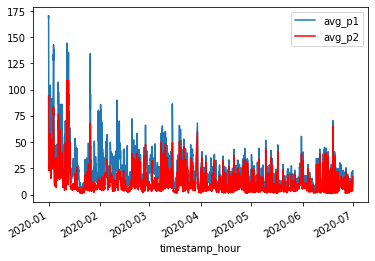

<Figure size 576x432 with 0 Axes>

+------------------------------------------+-------------------+------------------+------------------+
|window                                    |timestamp_hour     |avg_p1            |avg_p2            |
+------------------------------------------+-------------------+------------------+------------------+
|{2020-01-01 00:00:00, 2020-01-01 01:00:00}|2020-01-01 00:00:00|168.45603944759557|93.9130690074203  |
|{2020-01-01 01:00:00, 2020-01-01 02:00:00}|2020-01-01 01:00:00|170.62478617317657|91.32769248016879 |
|{2020-01-01 02:00:00, 2020-01-01 03:00:00}|2020-01-01 02:00:00|121.70207220369632|59.66360346476237 |
|{2020-01-01 03:00:00, 2020-01-01 04:00:00}|2020-01-01 03:00:00|97.87670051574707 |38.9539000749588  |
|{2020-01-01 04:00:00, 2020-01-01 05:00:00}|2020-01-01 04:00:00|100.02415252540071|39.41135581065033 |
|{2020-01-01 05:00:00, 2020-01-01 06:00:00}|2020-01-01 05:00:00|76.33341426384158 |34.73577234997013 |
|{2020-01-01 06:00:00, 2020-01-01 07:00:00}|2020-01-01 06:00:00|60.293057

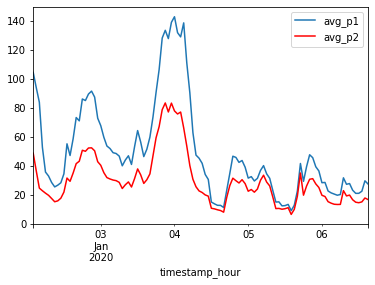

<Figure size 576x432 with 0 Axes>

+------------------------------------------+-------------------+------------------+------------------+
|window                                    |timestamp_hour     |avg_p1            |avg_p2            |
+------------------------------------------+-------------------+------------------+------------------+
|{2020-01-02 02:00:00, 2020-01-02 03:00:00}|2020-01-02 02:00:00|104.44992149621248|48.83773433417082 |
|{2020-01-02 03:00:00, 2020-01-02 04:00:00}|2020-01-02 03:00:00|93.91448501278373 |36.61007332100588 |
|{2020-01-02 04:00:00, 2020-01-02 05:00:00}|2020-01-02 04:00:00|83.86984774174582 |24.781984751461117|
|{2020-01-02 05:00:00, 2020-01-02 06:00:00}|2020-01-02 05:00:00|52.81394336592983 |22.96387327221078 |
|{2020-01-02 06:00:00, 2020-01-02 07:00:00}|2020-01-02 06:00:00|35.84621434211731 |21.30964289052146 |
|{2020-01-02 07:00:00, 2020-01-02 08:00:00}|2020-01-02 07:00:00|33.094453747532945|19.820504236622018|
|{2020-01-02 08:00:00, 2020-01-02 09:00:00}|2020-01-02 08:00:00|28.667647

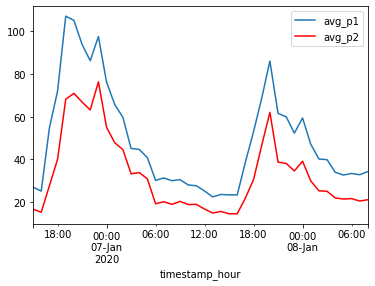

<Figure size 576x432 with 0 Axes>

+------------------------------------------+-------------------+------------------+------------------+
|window                                    |timestamp_hour     |avg_p1            |avg_p2            |
+------------------------------------------+-------------------+------------------+------------------+
|{2020-01-06 15:00:00, 2020-01-06 16:00:00}|2020-01-06 15:00:00|26.92466668287913 |16.61958335240682 |
|{2020-01-06 16:00:00, 2020-01-06 17:00:00}|2020-01-06 16:00:00|25.094426190266844|15.18934428496439 |
|{2020-01-06 17:00:00, 2020-01-06 18:00:00}|2020-01-06 17:00:00|54.685042927407814|27.57179497449826 |
|{2020-01-06 18:00:00, 2020-01-06 19:00:00}|2020-01-06 18:00:00|71.97133271353586 |40.024857039678665|
|{2020-01-06 19:00:00, 2020-01-06 20:00:00}|2020-01-06 19:00:00|107.06151741290914|68.11937919485158 |
|{2020-01-06 20:00:00, 2020-01-06 21:00:00}|2020-01-06 20:00:00|105.05263541465582|70.90899268601292 |
|{2020-01-06 21:00:00, 2020-01-06 22:00:00}|2020-01-06 21:00:00|93.812777

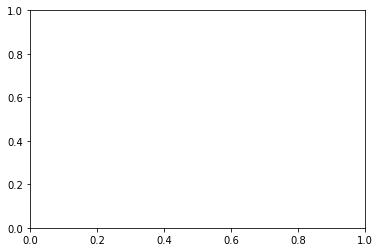

<Figure size 576x432 with 0 Axes>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# importing pandas library
import pandas as pd
# importing matplotlib library
import matplotlib.pyplot as plt



def dumpBatchDF(df, epoch_id):
    df = df.orderBy('window')
    ax = plt.gca()
    plt.figure(figsize=(8, 6))
    dfp = df.toPandas()
    dfp.plot(kind='line',x='timestamp_hour',y='avg_p1',ax=ax)
    dfp.plot(kind='line',x='timestamp_hour',y='avg_p2', color='red', ax=ax)
    plt.show()
    df.show(20, False)






spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')

query = lines.withWatermark('timestamp','1 seconds')\
      .groupBy(window(lines.timestamp,"1 hour","1 hour"), date_trunc("Hour",'timestamp').alias('timestamp_hour'))\
      .agg(avg('p1').alias('avg_p1'), avg('p2').alias('avg_p2'))

query = query \
    .writeStream \
    .outputMode('update') \
    .trigger(processingTime='1 seconds') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(200)
query.stop()
spark.stop()

4. The data covers a period of extensive population confinement due to Covid 19. Can you find a signal in the data showing air quality improvement coinciding with the confinement period?

R: By analysing the plot we see a decrease of the average air pollution from January to February and then it maintains till mid March where the lockdown was instated and afterwards we see another decrease which maintains till July (end of dataset).

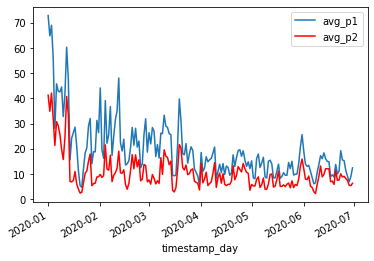

<Figure size 576x432 with 0 Axes>

+------------------------------------------+-------------------+------------------+------------------+
|window                                    |timestamp_day      |avg_p1            |avg_p2            |
+------------------------------------------+-------------------+------------------+------------------+
|{2020-01-01 00:00:00, 2020-01-02 00:00:00}|2020-01-01 00:00:00|72.91310271410406 |41.28459471360026 |
|{2020-01-02 00:00:00, 2020-01-03 00:00:00}|2020-01-02 00:00:00|64.85641002254326 |34.90484710004149 |
|{2020-01-03 00:00:00, 2020-01-04 00:00:00}|2020-01-03 00:00:00|69.02215701988993 |42.132719833871896|
|{2020-01-04 00:00:00, 2020-01-05 00:00:00}|2020-01-04 00:00:00|56.32841792309026 |32.28398636619497 |
|{2020-01-05 00:00:00, 2020-01-06 00:00:00}|2020-01-05 00:00:00|28.123103792562425|21.34564152018829 |
|{2020-01-06 00:00:00, 2020-01-07 00:00:00}|2020-01-06 00:00:00|45.81379689494312 |30.787486616770426|
|{2020-01-07 00:00:00, 2020-01-08 00:00:00}|2020-01-07 00:00:00|42.881273

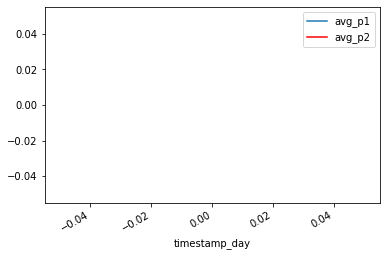

<Figure size 576x432 with 0 Axes>

+------+-------------+------+------+
|window|timestamp_day|avg_p1|avg_p2|
+------+-------------+------+------+
+------+-------------+------+------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# importing pandas library
import pandas as pd
# importing matplotlib library
import matplotlib.pyplot as plt

def plot(df, epoch_id):
    dfp = df.toPandas()
    # plotting a line graph
    print("Line graph: ")
    plt.plot(dfp["timestamp_hour"], dfp["avg_p1"])
    plt.show()

def dumpBatchDF(df, epoch_id):
    df = df.orderBy('window')
    ax = plt.gca()
    plt.figure(figsize=(8, 6))
    dfp = df.toPandas()
    dfp.plot(kind='line',x='timestamp_day',y='avg_p1',ax=ax)
    dfp.plot(kind='line',x='timestamp_day',y='avg_p2', color='red', ax=ax)
    plt.show()
    df.show(20, False)






spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')

query = lines.withWatermark('timestamp','24 seconds')\
      .groupBy(window(lines.timestamp,"1 day","1 day"), date_trunc("Day",'timestamp').alias('timestamp_day'))\
      .agg(avg('p1').alias('avg_p1'), avg('p2').alias('avg_p2'))

query = query \
    .writeStream \
    .outputMode('update') \
    .trigger(processingTime='10 seconds') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(100)
query.stop()
spark.stop()